# Selecting Context in LangGraph

*Selecting context means pulling it into the context window to help an agent perform a task.*

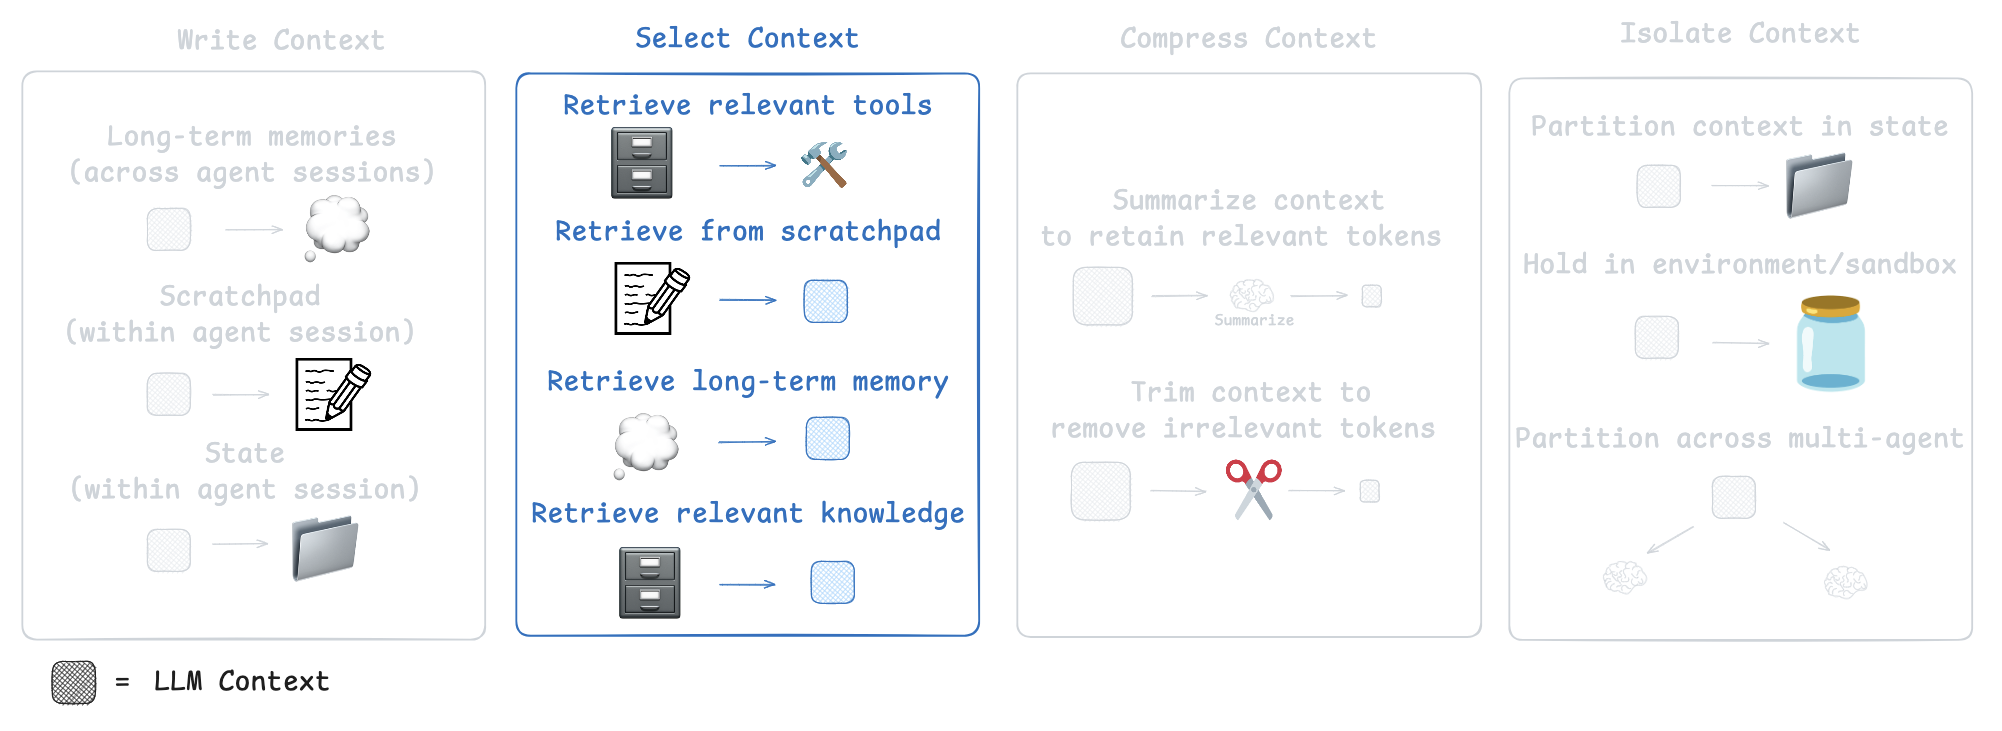

## Scratchpad

The mechanism for selecting context from a scratchpad depends upon how the scratchpad is implemented. If it’s a [tool](https://www.anthropic.com/engineering/claude-think-tool), then an agent can simply read it by making a tool call. If it’s part of the agent’s runtime state, then the developer can choose what parts of state to expose to an agent each step. This provides a fine-grained level of control for exposing context to an agent.

### Scratchpad selecting in LangGraph

In `1_write_context.ipynb`, we saw how to write to the LangGraph state object. Now, we'll see how to select context from state and present it to an LLM call in a downstream node. This ability to select from state gives us control over what context we present to LLM calls. 

In [1]:
from typing import TypedDict

from rich.console import Console
from rich.pretty import pprint

# Initialize console for rich formatting
console = Console()


class State(TypedDict):
    """State schema for the context selection workflow.
    
    Attributes:
        topic: The topic for joke generation
        joke: The generated joke content
    """
    topic: str
    joke: str

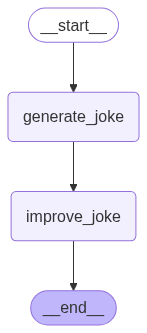

In [2]:
import getpass
import os

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.graph import END, START, StateGraph


def _set_env(var: str) -> None:
    """Set environment variable if not already set."""
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# Set up environment and initialize model
_set_env("OPENAI_API_KEY")
llm = init_chat_model("openai:gpt-5", temperature=0)

def generate_joke(state: State) -> dict[str, str]:
    """Generate an initial joke about the topic.
    
    Args:
        state: Current state containing the topic
        
    Returns:
        Dictionary with the generated joke
    """
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def improve_joke(state: State) -> dict[str, str]:
    """Improve an existing joke by adding wordplay.
    
    This demonstrates selecting context from state - we read the existing
    joke from state and use it to generate an improved version.
    
    Args:
        state: Current state containing the original joke
        
    Returns:
        Dictionary with the improved joke
    """
    print(f"Initial joke: {state['joke']}")
    
    # Select the joke from state to present it to the LLM
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


# Build the workflow with two sequential nodes
workflow = StateGraph(State)

# Add both joke generation nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)

# Connect nodes in sequence
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", "improve_joke")
workflow.add_edge("improve_joke", END)

# Compile the workflow
chain = workflow.compile()

# Display the workflow visualization
display(Image(chain.get_graph().draw_mermaid_png()))

In [4]:
# Execute the workflow to see context selection in action
joke_generator_state = chain.invoke({"topic": "cats"})

# Display the final state with rich formatting
console.print("\n[bold blue]Final Workflow State:[/bold blue]")
pprint(joke_generator_state)

Initial joke: I asked my cat why he sits on my laptop—he said, “I’m keeping an eye on the mouse.”


Final Workflow State:

{'topic': 'cats', 'joke': 'I asked my cat why he sits on my laptop—he said, “I’m keeping an eye on the mouse.”'}

## Memory

If agents have the ability to save memories, they also need the ability to select memories relevant to the task they are performing. This can be useful for a few reasons. Agents might select few-shot examples ([episodic](https://langchain-ai.github.io/langgraph/concepts/memory/#memory-types) [memories](https://arxiv.org/pdf/2309.02427)) for examples of desired behavior, instructions ([procedural](https://langchain-ai.github.io/langgraph/concepts/memory/#memory-types) [memories](https://arxiv.org/pdf/2309.02427)) to steer behavior, or facts ([semantic](https://langchain-ai.github.io/langgraph/concepts/memory/#memory-types) [memories](https://arxiv.org/pdf/2309.02427)) give the agent task-relevant context.

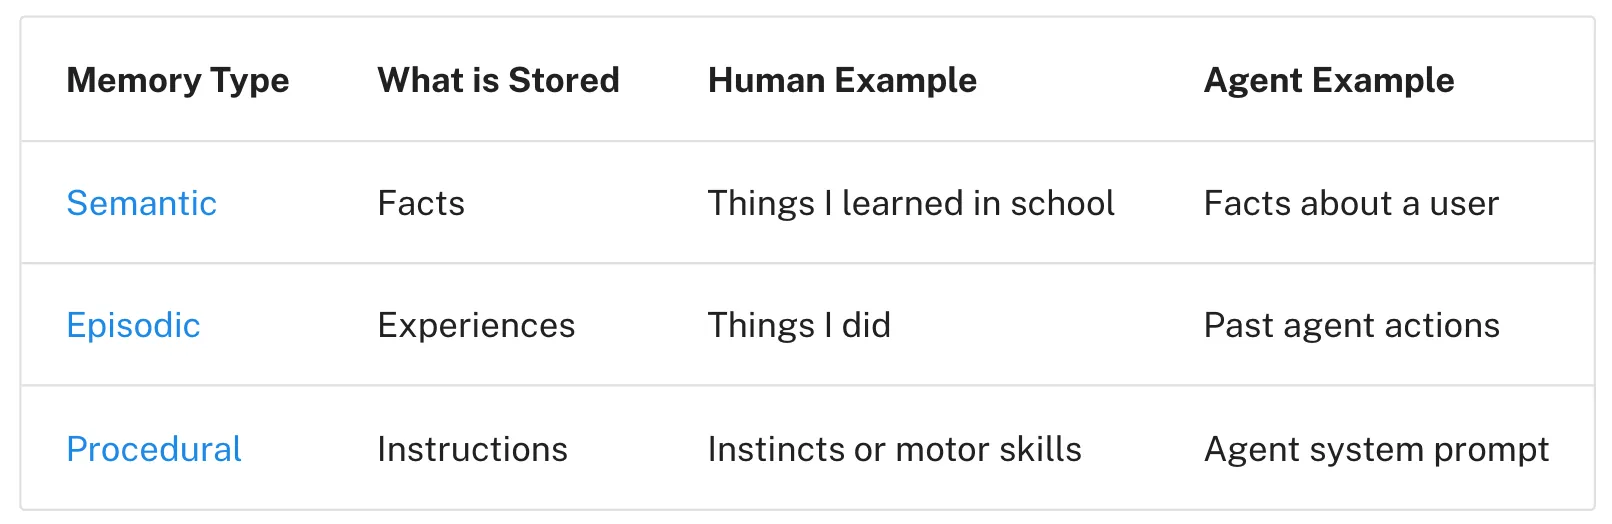

One challenge is ensure that relevant memories are selected. Some popular agents simply use a narrow set of files to store memories. For example, many code agent use “rules” files to save instructions (”procedural” memories) or, in some cases, examples (”episodic” memories). Claude Code uses [`CLAUDE.md`](http://CLAUDE.md). [Cursor](https://docs.cursor.com/context/rules) and [Windsurf](https://windsurf.com/editor/directory) use rules files. These are always pulled into context.

But, if an agent is storing a larger [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection) of facts and / or relationships ([semantic](https://langchain-ai.github.io/langgraph/concepts/memory/#memory-types) memories), selection is harder. [ChatGPT](https://help.openai.com/en/articles/8590148-memory-faq) is a good example of this. At the AIEngineer World’s Fair, [Simon Willison shared](https://simonwillison.net/2025/Jun/6/six-months-in-llms/) a good example of memory selection gone wrong: ChatGPT fetched his location and injected it into an image that he requested. This type of erroneous memory retrieval can make users feel like the context winder “*no longer belongs to them*”! Use of embeddings and / or [knowledge](https://arxiv.org/html/2501.13956v1#:~:text=In%20Zep%2C%20memory%20is%20powered,subgraph%2C%20and%20a%20community%20subgraph) [graphs](https://neo4j.com/blog/developer/graphiti-knowledge-graph-memory/#:~:text=changes%20since%20updates%20can%20trigger,and%20holistic%20memory%20for%20agentic) for indexing of memories have been used to assist with selection.

### Memory selecting in LangGraph

In `1_write_context.ipynb`, we saw how to write to `InMemoryStore` in graph nodes. Now let's select state from it. We can use the [get](https://langchain-ai.github.io/langgraph/concepts/memory/#memory-storage) method to select context from state.

In [5]:
from langgraph.store.memory import InMemoryStore

# Initialize the memory store
store = InMemoryStore()

# Define namespace for organizing memories
namespace = ("rlm", "joke_generator")

# Store the generated joke in memory
store.put(
    namespace,                             # namespace for organization
    "last_joke",                          # key identifier
    {"joke": joke_generator_state["joke"]} # value to store
)

# Select (retrieve) the joke from memory
retrieved_joke = store.get(namespace, "last_joke").value

# Display the retrieved context
console.print("\n[bold green]Retrieved Context from Memory:[/bold green]")
pprint(retrieved_joke)

Retrieved Context from Memory:

{'joke': 'I asked my cat why he sits on my laptop—he said, “I’m keeping an eye on the mouse.”'}

In [13]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

# Initialize storage components
checkpointer = InMemorySaver()
memory_store = InMemoryStore()


def generate_joke(state: State, store: BaseStore) -> dict[str, str]:
    """Generate a joke with memory-aware context selection.
    
    This function demonstrates selecting context from memory before
    generating new content, ensuring consistency and avoiding duplication.
    
    Args:
        state: Current state containing the topic
        store: Memory store for persistent context
        
    Returns:
        Dictionary with the generated joke
    """
    # Select prior joke from memory if it exists
    prior_joke = store.get(namespace, "last_joke")
    if prior_joke:
        prior_joke_text = prior_joke.value["joke"]
        print(f"Prior joke: {prior_joke_text}")
    else:
        print("Prior joke: None!")

    # Generate a new joke that differs from the prior one
    prompt = (
        f"Write a short joke about {state['topic']}, "
        f"but make it different from any prior joke you've written: {prior_joke_text if prior_joke else 'None'}"
    )
    msg = llm.invoke(prompt)

    # Store the new joke in memory for future context selection
    store.put(namespace, "last_joke", {"joke": msg.content})

    return {"joke": msg.content}


# Build the memory-aware workflow
workflow = StateGraph(State)
workflow.add_node("generate_joke", generate_joke)

# Connect the workflow
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", END)

# Compile with both checkpointing and memory store
chain = workflow.compile(checkpointer=checkpointer, store=memory_store)

In [14]:
# Execute the workflow with the first thread
config = {"configurable": {"thread_id": "1"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

Prior joke: None!


In [15]:
# Get the latest state of the graph
latest_state = chain.get_state(config)

console.print("\n[bold magenta]Latest Graph State:[/bold magenta]")
pprint(latest_state)

Latest Graph State:

StateSnapshot(
│   values={
│   │   'topic': 'cats',
│   │   'joke': 'My cat doesn’t knock glasses off tables—he schedules them. Calendar invite: “Gravity demo,” attendees: Dad’s water.'
│   },
│   next=(),
│   config={
│   │   'configurable': {
│   │   │   'thread_id': '1',
│   │   │   'checkpoint_ns': '',
│   │   │   'checkpoint_id': '1f09178a-e53d-686a-8001-b33939332b36'
│   │   }
│   },
│   metadata={'source': 'loop', 'step': 1, 'parents': {}},
│   created_at='2025-09-14T14:39:55.531853+00:00',
│   parent_config={
│   │   'configurable': {
│   │   │   'thread_id': '1',
│   │   │   'checkpoint_ns': '',
│   │   │   'checkpoint_id': '1f09178a-3dc5-689e-8000-7d5db78b2856'
│   │   }
│   },
│   tasks=(),
│   interrupts=()
)

We fetch the prior joke from memory and pass it to an LLM to improve it!

In [16]:
# Execute the workflow with a second thread to demonstrate memory persistence
config = {"configurable": {"thread_id": "2"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

Prior joke: My cat doesn’t knock glasses off tables—he schedules them. Calendar invite: “Gravity demo,” attendees: Dad’s water.


## Tools

Agents use tools, but can become overloaded if they are provided with too many. This is often because the tool descriptions can overlap, causing model confusion about which tool to use. One approach is to apply RAG to tool descriptions in order to fetch the most relevant tools for a task based upon semantic similarity, an idea that Drew Breunig calls “[tool loadout](https://www.dbreunig.com/2025/06/26/how-to-fix-your-context.html).” Some [recent papers](https://arxiv.org/abs/2505.03275) have shown that this improve tool selection accuracy by 3-fold.

### Tool selecting in LangGraph

For tool selection, the [LangGraph Bigtool](https://github.com/langchain-ai/langgraph-bigtool) library is a great way to apply semantic similarity search over tool descriptions for selection of the most relevant tools for a task. It leverages LangGraph's long-term memory store to allow an agent to search for and retrieve relevant tools for a given problem. Lets demonstrate `langgraph-bigtool` by equipping an agent with all functions from Python's built-in math library.

/var/folders/nv/z0qs8q8n0253wr64dgszlp880000gp/T/ipykernel_29978/1646477823.py:24: LangChainBetaWarning: The function `convert_positional_only_function_to_tool` is in beta. It is actively being worked on, so the API may change.
  if tool := convert_positional_only_function_to_tool(


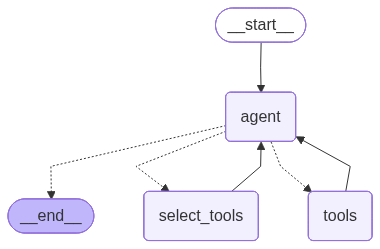

In [3]:
import math
import types
import uuid

from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore

from langgraph_bigtool import create_agent
from langgraph_bigtool.utils import (
    convert_positional_only_function_to_tool
)

_set_env("OPENAI_API_KEY")

# Collect functions from `math` built-in
all_tools = []
for function_name in dir(math):
    function = getattr(math, function_name)
    if not isinstance(
        function, types.BuiltinFunctionType
    ):
        continue
    # This is an idiosyncrasy of the `math` library
    if tool := convert_positional_only_function_to_tool(
        function
    ):
        all_tools.append(tool)

# Create registry of tools. This is a dict mapping
# identifiers to tool instances.
tool_registry = {
    str(uuid.uuid4()): tool
    for tool in all_tools
}

# Index tool names and descriptions in the LangGraph
# Store. Here we use a simple in-memory store.
embeddings = init_embeddings("openai:text-embedding-3-small")

store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
        "fields": ["description"],
    }
)
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),
        tool_id,
        {
            "description": f"{tool.name}: {tool.description}",
        },
    )

# Initialize agent
builder = create_agent(llm, tool_registry)
agent = builder.compile(store=store)
agent

In [ ]:
from utils import format_messages
query = "Use available tools to calculate arc cosine of 0.5."
result = agent.invoke({"messages": query})
format_messages(result['messages'])

[HumanMessage(content='Use available tools to calculate arc cosine of 0.5.', additional_kwargs={}, response_metadata={}, id='da87ef89-8391-4b17-b7f8-97cc22adac26'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_K6yK3xyMzBymp5Ah3lJJjZnC', 'function': {'arguments': '{"query":"arccos calculator or math tool"}', 'name': 'retrieve_tools'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 669, 'prompt_tokens': 142, 'total_tokens': 811, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 640, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CFiPRA9pM7fEnUPDqBQ1jvg842ATS', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0d3fcefb-37ef-482e-9bc2-c2350f0ee03f-0', tool_calls=[{'name': 'retrieve_tools', 'args': {'qu

### Learn more

* **Toolshed: Scale Tool-Equipped Agents with Advanced RAG-Tool Fusion** - Lumer, E., Subbiah, V.K., Burke, J.A., Basavaraju, P.H. & Huber, A. (2024). arXiv:2410.14594.

The paper introduces Toolshed Knowledge Bases and Advanced RAG-Tool Fusion to address challenges in scaling tool-equipped AI agents. The Toolshed Knowledge Base is a vector database designed to store enhanced tool representations and optimize tool selection for large-scale tool-equipped agents. The Advanced RAG-Tool Fusion technique applies retrieval-augmented generation across three phases: pre-retrieval (tool document enhancement), intra-retrieval (query planning and transformation), and post-retrieval (document refinement and self-reflection). The researchers demonstrated significant performance improvements, achieving 46%, 56%, and 47% absolute improvements on different benchmark datasets (Recall@5), all without requiring model fine-tuning.

* **Graph RAG-Tool Fusion** - Lumer, E., Basavaraju, P.H., Mason, M., Burke, J.A. & Subbiah, V.K. (2025). arXiv:2502.07223.

This paper addresses limitations in current RAG approaches for tool selection by introducing Graph RAG-Tool Fusion, which combines vector-based retrieval with graph traversal to capture tool dependencies. Traditional RAG methods fail to capture structured dependencies between tools (e.g., a "get stock price" API requiring a "stock ticker" parameter from another API). The authors present ToolLinkOS, a benchmark dataset with 573 fictional tools across 15 industries, each averaging 6.3 tool dependencies. Graph RAG-Tool Fusion achieved absolute improvements of 71.7% and 22.1% over naïve RAG on ToolLinkOS and ToolSandbox benchmarks, respectively, by understanding and navigating interconnected tool relationships within a predefined knowledge graph.

* **LLM-Tool-Survey** - https://github.com/quchangle1/LLM-Tool-Survey

This comprehensive survey repository explores Tool Learning with Large Language Models, presenting a systematic examination of how AI models can effectively use external tools to enhance their capabilities. The repository covers key aspects including benefits of tools (knowledge acquisition, expertise enhancement, interaction improvement) and technical workflows. It provides an extensive collection of research papers categorized by tool types, reasoning methods, and technological approaches, ranging from mathematical tools and programming interpreters to multi-modal and domain-specific applications. The repository serves as a valuable collaborative resource for researchers and practitioners interested in the evolving landscape of AI tool integration.

* **Retrieval Models Aren't Tool-Savvy: Benchmarking Tool Retrieval** - Shi, Z., Wang, Y., Yan, L., Ren, P., Wang, S., Yin, D. & Ren, Z. arXiv:2503.01763.

The paper introduces ToolRet, a benchmark for evaluating tool retrieval capabilities of information retrieval (IR) models in LLM contexts. Unlike existing benchmarks that manually pre-annotate small sets of relevant tools, ToolRet comprises 7.6k diverse retrieval tasks and a corpus of 43k tools from existing datasets. The research found that even IR models with strong performance in conventional benchmarks exhibit poor performance on ToolRet, directly impacting task success rates of tool-using LLMs. As a solution, the researchers contributed a large-scale training dataset with over 200k instances that substantially optimizes tool retrieval ability, bridging the gap between existing approaches and real-world tool-learning scenarios.

## Knowledge 

[RAG](https://github.com/langchain-ai/rag-from-scratch) (retrieval augmented generation) is an extremely rich topic. Code agents are some of the best examples of agentic RAG in large-scale production. [In practice, RAG is can be a central context engineering challenge](https://x.com/_mohansolo/status/1899630246862966837). Varun from Windsurf captures some of these challenges well:

> Indexing code ≠ context retrieval … [We are doing indexing & embedding search … [with] AST parsing code and chunking along semantically meaningful boundaries … embedding search becomes unreliable as a retrieval heuristic as the size of the codebase grows … we must rely on a combination of techniques like grep/file search, knowledge graph based retrieval, and … a re-ranking step where [context] is ranked in order of relevance. 

### RAG in LangGraph

There are several [tutorials and videos](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/) that show how to use RAG with LangGraph. When combining RAG with agents in LangGraph, it's common to build a retrieval tool. Note that this tool could incorporate any combination of RAG techniques, as mentioned above.

Fetch documents to use in our RAG system. We will use three of the most recent pages from Lilian Weng's excellent blog. We'll start by fetching the content of the pages using WebBaseLoader utility.

In [15]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

USER_AGENT environment variable not set, consider setting it to identify your requests.


Split the fetched documents into smaller chunks for indexing into our vectorstore.

In [16]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

Now that we have our split documents, we can index them into a vector store that we'll use for semantic search.

In [17]:
from langchain_core.vectorstores import InMemoryVectorStore

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()

Create a retriever tool that we can use in our agent.

In [18]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

# retriever_tool.invoke({"query": "types of reward hacking"})

Now, implement an agent that can select context from the tool.

In [19]:
# Augment the LLM with tools
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

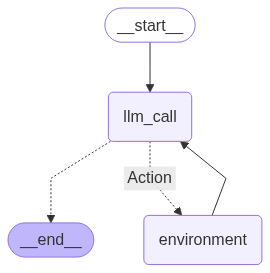

In [20]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, ToolMessage
from typing_extensions import Literal

rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng. 
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content=rag_prompt
                    )
                ]
                + state["messages"]
            )
        ]
    }
    
def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from utils import format_messages
query = "What are the types of reward hacking discussed in the blogs?"
result = agent.invoke({"messages": query})
format_messages(result['messages'])